# Solving a linear system of equation implicitly using PyTorch

improvements:

- use mini-batch
    - have to sort the problem with the sparse matrix
- optimize adam

In [1]:
# imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from scipy.sparse.linalg import spsolve
import scipy
from time import time
import contextlib

@contextlib.contextmanager
def timer(msg='timer'):
    tic = time()
    yield
    return print(f"{msg}: {time() - tic:.2f}")

In [38]:
n = 50

dx_sq = (1.0/(n-1))**2#(1.0/n)**2
K = 1.0 # diffusivity
lr = 0.5#0.0005*dx_sq # learning rate
s = 20.0  # source term
lr

0.5

In [39]:
# Define the ground truth of the RHS
# b_gt = -s*torch.ones(n)
b_gt = -0.5*s/K*dx_sq*torch.ones(n)
# Apply BC to RHS
with torch.no_grad():
    b_gt[0] = 0.0
    b_gt[-1] = 1.0

In [40]:
A = np.zeros((n,n))
# with torch.no_grad():
for i in range(1,n-1):
#     A[i,i-1] =  K*1.0/dx_sq
#     A[i,i  ] = -K*2.0/dx_sq
#     A[i,i+1] =  K*1.0/dx_sq
    A[i,i-1] =  0.5
    A[i,i  ] = -1.0
    A[i,i+1] =  0.5
# BC
A[0,0] = 1.0
A[-1,-1] = 1.0

A_numpy = scipy.sparse.coo_matrix(A)
# A = torch.from_numpy(A)
A = torch.sparse_coo_tensor(np.array([A_numpy.row,A_numpy.col]),A_numpy.data,dtype=torch.float32)

## Doing gradient descent by hand

In [41]:
# Compute
x = torch.zeros(n, requires_grad=True)
lr = 0.5
for i in range(10000):
    b = A@x
    loss = ((b-b_gt)**2).mean()
    loss.backward()
    with torch.no_grad():
        x -= lr*x.grad
        if (i%1000==0):
            print(f"i: {i}, loss: {loss:.3e}")
#             print("x_grad: ", x.grad)
#             print("x: ", x)
#             print("\n")
    x.grad.zero_()    

i: 0, loss: 2.002e-02
i: 1000, loss: 2.202e-04
i: 2000, loss: 1.423e-04
i: 3000, loss: 1.124e-04
i: 4000, loss: 9.600e-05
i: 5000, loss: 8.539e-05
i: 6000, loss: 7.786e-05
i: 7000, loss: 7.221e-05
i: 8000, loss: 6.777e-05
i: 9000, loss: 6.417e-05


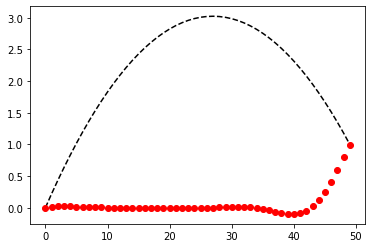

In [42]:
# Visu
with torch.no_grad():
    x_ref = scipy.sparse.linalg.spsolve(A_numpy.tocsr(),b_gt)
    plt.plot(x_ref,'--k')
    plt.plot(x,'or')

### Comment
It works but it is somehow incredibly slow

## Using PyTorch's optiimzer

In [164]:


# Define the ground truth of the RHS
# b_gt = -s*torch.ones(n,1)
b_gt = -0.5*s/K*dx_sq*torch.ones(n,1)
# Apply BC to RHS
with torch.no_grad():
    b_gt[0] = 0.0
    b_gt[-1] = 1.0

    
def solve_w_torch(A,b_gt):
#     loss_func = nn.MSELoss(reduction='mean')
    loss_func = nn.MSELoss(reduction='mean')

    
    x = nn.Linear(n,1,bias=False)
    
    net = nn.Sequential(x)
    # Define an optimizer
    lr = 0.6
#     trainer = torch.optim.SGD(net.parameters(), lr=lr)
#     trainer = torch.optim.SGD(net.parameters(), lr=lr)
    trainer = torch.optim.Adam(net.parameters())

    loss = 1.0
    i = 0
    while loss>1e-6 and i<150000:

        b = net(A)  
        loss = loss_func(b,b_gt)
#         loss = ((b-b_gt)**2).max()
        trainer.zero_grad()
        loss.backward()
        trainer.step()
        
        if (i%5000==0):
            
            print(f"i: {i}, loss : {loss:.3e}")
#             print(f"i: {i}, loss2: {((b-b_gt)**2).max():.3e}")
        i+=1
    return next(net.parameters())[0]
    #             print("x_grad: ", x.grad)
    #             print("x: ", x)
    #             print("\n")



timer: 0.00
i: 0, loss : 3.269e-02
i: 5000, loss : 3.645e-05
i: 10000, loss : 2.005e-05
i: 15000, loss : 1.342e-05
i: 20000, loss : 9.024e-06
i: 25000, loss : 6.070e-06
i: 30000, loss : 4.083e-06
i: 35000, loss : 2.745e-06
i: 40000, loss : 1.849e-06
i: 45000, loss : 1.253e-06
timer: 14.37


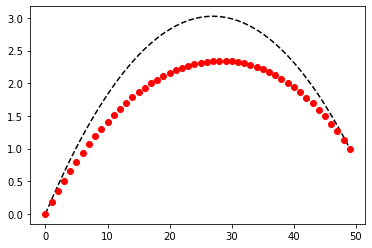

In [165]:
with timer():
    x_ref = scipy.sparse.linalg.spsolve(A_numpy.tocsr(),b_gt)

with timer():
    x_torch = solve_w_torch(A,b_gt)

with torch.no_grad():    
    plt.plot(x_ref, '--k')    
    plt.plot(x_torch, 'or')    

In [63]:
with torch.no_grad():    
    plt.plot(x_ref, '--k')   5
    plt.plot(x_torch, 'or')    

SyntaxError: invalid syntax (<ipython-input-63-654ed23f0562>, line 2)

In [162]:
b

tensor([-4.4946e-04, -3.2671e-03, -2.4127e-03, -1.6396e-03, -9.7729e-04,
        -4.4449e-04, -4.7848e-05,  2.1761e-04,  3.6659e-04,  4.2065e-04,
         4.0476e-04,  3.4387e-04,  2.6005e-04,  1.7059e-04,  8.7222e-05,
         1.6591e-05, -3.8394e-05, -7.6660e-05, -9.7139e-05, -9.7578e-05,
        -7.4499e-05, -2.4566e-05,  5.2746e-05,  1.5176e-04,  2.5744e-04,
         3.4383e-04,  3.7524e-04,  3.1129e-04,  1.1582e-04, -2.3097e-04,
        -7.1953e-04, -1.2999e-03, -1.8761e-03, -2.3099e-03, -2.4345e-03,
        -2.0801e-03, -1.1068e-03,  5.5878e-04,  2.8915e-03,  5.7472e-03,
         8.8604e-03,  1.1865e-02,  1.4335e-02,  1.5845e-02,  1.6038e-02,
         1.4688e-02,  1.1748e-02,  7.3708e-03,  1.9018e-03,  9.9696e-01],
       grad_fn=<MvBackward>)

In [166]:
b_gt

tensor([[ 0.0000],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [-0.0042],
        [ 1.0000]])